이미지 크기: (512, 512)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


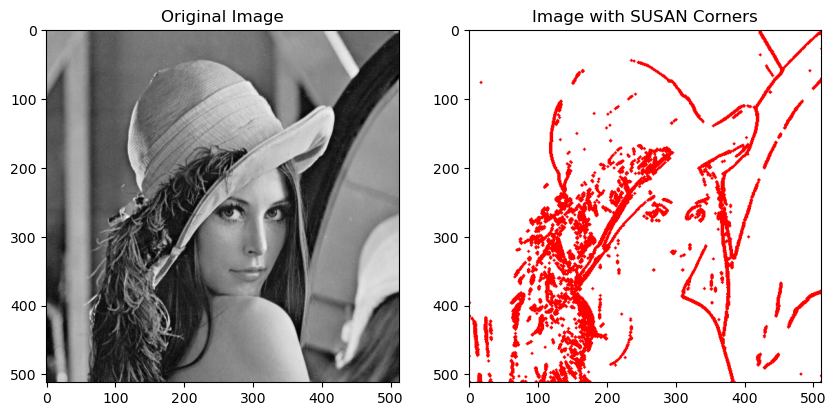

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 이미지 로드 (cv2 사용)
def load_image_as_gray(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"이미지를 로드할 수 없습니다: {image_path}")
    return np.array(img, dtype=np.float32)

# 2. SUSAN 마스크 생성 (반지름 3.4에 근사한 37픽셀 마스크)
def create_susan_mask():
    # 7x7 마스크에서 원형 영역 정의 (중심 포함 37개 픽셀)
    mask = np.zeros((7, 7), dtype=np.int32)
    center = 3  # 마스크 중심
    offsets = [
        (-3, 0), (-2, -2), (-2, -1), (-2, 0), (-2, 1), (-2, 2),
        (-1, -3), (-1, -2), (-1, -1), (-1, 0), (-1, 1), (-1, 2), (-1, 3),
        (0, -3), (0, -2), (0, -1), (0, 0), (0, 1), (0, 2), (0, 3),
        (1, -3), (1, -2), (1, -1), (1, 0), (1, 1), (1, 2), (1, 3),
        (2, -2), (2, -1), (2, 0), (2, 1), (2, 2),
        (3, 0)
    ]
    for dy, dx in offsets:
        mask[center + dy, center + dx] = 1
    return mask, offsets

# 3. SUSAN 알고리즘 구현
def susan_corner_detection(image, t=25):
    h, w = image.shape
    mask, offsets = create_susan_mask()
    mask_size = len(offsets)  # 37
    response = np.zeros((h, w), dtype=np.float32)

    # 이미지 패딩 (마스크 크기에 맞게)
    padded_img = np.pad(image, ((3, 3), (3, 3)), mode='constant')

    # 각 픽셀에 대해 USAN 계산
    for y in range(h):
        for x in range(w):
            center_value = image[y, x]
            n = 0  # USAN 크기
            for dy, dx in offsets:
                neighbor_value = padded_img[y + 3 + dy, x + 3 + dx]
                if abs(center_value - neighbor_value) <= t:
                    n += 1
            
            # SUSAN 응답 계산
            # n이 mask_size의 절반 근처일 때 코너로 간주
            g = mask_size / 2  # 기하학적 임계값
            if n < g:
                response[y, x] = g - n
            else:
                response[y, x] = 0

    return response

# 4. 코너 위치를 원본 이미지에 오버레이
def overlay_corners_on_image(original_img, corner_response, threshold=0.1):
    original_color = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)
    corners_y, corners_x = np.where(corner_response > threshold * np.max(corner_response))
    
    for y, x in zip(corners_y, corners_x):
        cv2.circle(original_color, (x, y), 2, (255, 0, 0), -1)  # 빨간색 점

    return original_color

# 5. 결과 시각화
def plot_results(original_img, overlay_img):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_img, cmap='gray')
    
    plt.subplot(1, 2, 2)
    plt.title("Image with SUSAN Corners")
    plt.imshow(overlay_img)
    plt.show()

# 6. 메인 실행
if __name__ == "__main__":
    image_path = "./image/lena.bmp"  # 실제 이미지 경로로 변경
    gray_image = load_image_as_gray(image_path)
    print(f"이미지 크기: {gray_image.shape}")
    
    # SUSAN 코너 검출
    t = 25  # 밝기 차이 임계값
    corner_response = susan_corner_detection(gray_image, t)
    
    # 코너 오버레이
    overlay_image = overlay_corners_on_image(gray_image, corner_response, threshold=0.1)
    
    # 결과 시각화
    plot_results(gray_image, overlay_image)